In [1]:
import pandas as pd
pd.options.display.float_format = '{:.3f}'.format
pd.set_option("display.max_rows", None)  # 모든 행 출력
pd.set_option("display.max_columns", None)  # 모든 열 출력
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB
import os
from itertools import product
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from tqdm import tqdm
from functions import (load_parameters, load_generation_data, load_price_data, generate_randomized_generation,
generate_rt_scenarios, plot_generation_data, plot_randomized_generation, plot_scenarios_for_generator, plot_rt_scenarios, plot_summary)

generation_data, I, T = load_generation_data(date_filter="2022-07-18")
S, R, P_RT, K, K0, M1, M2 = load_parameters(I, T, generation_data)
P_DA, P_PN = load_price_data()

✅ 총 4개 파일을 불러왔습니다: 1201.csv, 137.csv, 397.csv, 514.csv
📊 데이터 Shape: I=4, T=24, S=20
✅ 시뮬레이션 초기화 완료: S=20, Randomness='high', M1=486.00, M2=924.00


In [2]:
def optimize_without(target_i, R, K, K0, P_DA, P_RT, P_PN, I, T, S):
    I_set = [i for i in range(I) if i != target_i]
    M1 = np.maximum(R[I_set], K[I_set, None, None]).max()
    M2 = max(R[I_set].sum(axis=0).max(), K[I_set].sum())

    model = gp.Model(f"set_without_{target_i}")
    model.setParam("MIPGap", 1e-7)
    model.setParam("OutputFlag", 0)

    x = model.addVars(I_set, T, vtype=GRB.CONTINUOUS, lb=0, name="x")
    ep = model.addVars(I_set, T, S, vtype=GRB.CONTINUOUS, name="e_plus")
    em = model.addVars(I_set, T, S, vtype=GRB.CONTINUOUS, name="e_minus")
    yp = model.addVars(I_set, T, S, vtype=GRB.CONTINUOUS, lb=0, name="y_plus")
    ym = model.addVars(I_set, T, S, vtype=GRB.CONTINUOUS, lb=0, name="y_minus")
    z = model.addVars(I_set, T + 1, S, vtype=GRB.CONTINUOUS, name="z")
    zc = model.addVars(I_set, T, S, vtype=GRB.CONTINUOUS, name="z_charge")
    zd = model.addVars(I_set, T, S, vtype=GRB.CONTINUOUS, name="z_discharge")
    d = model.addVars(I_set, I_set, T, S, vtype=GRB.CONTINUOUS, lb=0, name="d")

    p1 = model.addVars(I_set, T, S, vtype=GRB.BINARY, name="p1")
    p2 = model.addVars(I_set, T, S, vtype=GRB.BINARY, name="p2")
    p3 = model.addVars(I_set, T, S, vtype=GRB.BINARY, name="p3")
    p4 = model.addVars(I_set, T, S, vtype=GRB.BINARY, name="p4")

    obj = gp.quicksum(P_DA[t] * x[i, t] for i in I_set for t in range(T)) + gp.quicksum(
        (1 / S) * (
            P_RT[t, s] * gp.quicksum(ep[i, t, s] for i in I_set) -
            P_PN[t] * gp.quicksum(em[i, t, s] for i in I_set)
        )
        for t in range(T) for s in range(S)
    )
    model.setObjective(obj, GRB.MAXIMIZE)

    for i, t, s in product(I_set, range(T), range(S)):
        model.addConstr(R[i, t, s] - x[i, t] == yp[i, t, s] - ym[i, t, s] + zc[i, t, s] - zd[i, t, s])
        model.addConstr(yp[i, t, s] <= R[i, t, s])
        model.addConstr(zd[i, t, s] <= z[i, t, s])
        model.addConstr(zc[i, t, s] <= K[i] - z[i, t, s])
        model.addConstr(yp[i, t, s] <= M1 * p3[i, t, s])
        model.addConstr(ym[i, t, s] <= M1 * (1 - p3[i, t, s]))
        model.addConstr(ym[i, t, s] <= M1 * p2[i, t, s])
        model.addConstr(zc[i, t, s] <= M1 * (1 - p2[i, t, s]))
        model.addConstr(zc[i, t, s] <= M1 * p1[i, t, s])
        model.addConstr(zd[i, t, s] <= M1 * (1 - p1[i, t, s]))
        model.addConstr(z[i, t, s] <= K[i])
        model.addConstr(z[i, t + 1, s] == z[i, t, s] + zc[i, t, s] - zd[i, t, s])

    for i, s in product(I_set, range(S)):
        model.addConstr(z[i, 0, s] == K0[i])

    for i, t, s in product(I_set, range(T), range(S)):
        model.addConstr(ep[i, t, s] == yp[i, t, s] - gp.quicksum(d[i, j, t, s] for j in I_set if j != i))
        model.addConstr(em[i, t, s] == ym[i, t, s] - gp.quicksum(d[j, i, t, s] for j in I_set if j != i))
        model.addConstr(gp.quicksum(ep[i, t, s] for i in I_set) <= M2 * p4[i, t, s])
        model.addConstr(gp.quicksum(em[i, t, s] for i in I_set) <= M2 * (1 - p4[i, t, s]))
        model.addConstr(d[i, i, t, s] == 0)

    model.optimize()

    i_map = {i: idx for idx, i in enumerate(I_set)}

    yp_vals = np.array([[[yp[i, t, s].X for s in range(S)] for t in range(T)] for i in I_set])
    ym_vals = np.array([[[ym[i, t, s].X for s in range(S)] for t in range(T)] for i in I_set])
    d_vals = np.array([[[[d[i, j, t, s].X for s in range(S)] for t in range(T)] for j in I_set] for i in I_set])

    return yp_vals, ym_vals, d_vals, i_map

In [3]:
def optimize_without_forall(R, K, K0, P_DA, P_RT, P_PN, I, T, S):
    yp_without = {}
    ym_without = {}
    d_without = {}
    i_map_without = {}

    for target_i in tqdm(range(I), desc="Solving settlement model for each target DER"):
        yp_vals, ym_vals, d_vals, i_map = optimize_without(
            target_i, R, K, K0, P_DA, P_RT, P_PN, I, T, S
        )
        yp_without[target_i] = yp_vals
        ym_without[target_i] = ym_vals
        d_without[target_i] = d_vals
        i_map_without[target_i] = i_map

    return yp_without, ym_without, d_without, i_map_without

In [ ]:
yp_without, ym_without, d_without, i_map_without = optimize_without_forall(R, K, K0, P_DA, P_RT, P_PN, I, T, S)

Solving settlement model for each target DER:   0%|          | 0/4 [00:00<?, ?it/s]

Set parameter Username
Set parameter LicenseID to value 2611964
Academic license - for non-commercial use only - expires 2026-01-20
Set parameter MIPGap to value 1e-07


Solving settlement model for each target DER:  25%|██▌       | 1/4 [00:03<00:10,  3.43s/it]

Set parameter MIPGap to value 1e-07


Solving settlement model for each target DER:  50%|█████     | 2/4 [00:05<00:04,  2.46s/it]

Set parameter MIPGap to value 1e-07


Solving settlement model for each target DER:  75%|███████▌  | 3/4 [00:07<00:02,  2.40s/it]

Set parameter MIPGap to value 1e-07


Solving settlement model for each target DER: 100%|██████████| 4/4 [00:09<00:00,  2.39s/it]


In [5]:
def compute_price_functions(
    yp_without, ym_without, d_without, i_map_without,
    P_RT, P_PN, T, S, I
):
    rdc_coefficients_all = np.full((I, T, S, 2), np.nan)
    rsc_coefficients_all = np.full((I, T, S, 2), np.nan)
    rho_plus_func_all = np.full((I, T, S, 2), np.nan)   # RDC
    rho_minus_func_all = np.full((I, T, S, 2), np.nan)  # RSC
    
    total_demand_all = np.zeros((I, T, S))
    total_supply_all = np.zeros((I, T, S))

    for target_i in range(I):
        yp_vals = yp_without[target_i]
        ym_vals = ym_without[target_i]
        d_vals = d_without[target_i]
        i_map = i_map_without[target_i]

        for t in range(T):
            for s in range(S):
                total_supply = sum(yp_vals[i_map[i], t, s] for i in i_map)
                total_demand = sum(ym_vals[i_map[i], t, s] for i in i_map)
                
                total_supply_all[target_i, t, s] = total_supply
                total_demand_all[target_i, t, s] = total_demand

                given_profit = received_profit = realized_supply = realized_demand = 0
                for i in i_map:
                    for j in i_map:
                        if i == j: continue
                        given_profit += d_vals[i_map[i], i_map[j], t, s] * P_PN[t]
                        received_profit += d_vals[i_map[j], i_map[i], t, s] * P_RT[t, s]
                        realized_supply += d_vals[i_map[i], i_map[j], t, s]
                        realized_demand += d_vals[i_map[j], i_map[i], t, s]

                BIG_M_POS = 1e6
                BIG_M_NEG = -1e6

                if realized_demand <= 1e-4 or realized_supply <= 1e-4:
                    rho_plus_func_all[target_i, t, s, :] = [BIG_M_NEG, 0.0]
                    rho_minus_func_all[target_i, t, s, :] = [BIG_M_POS, 0.0]
                    continue

                a_d = P_PN[t]
                b_d = 2 * (a_d * realized_demand - received_profit) / (realized_demand ** 2)
                a_s = P_RT[t, s]
                b_s = 2 * (given_profit - a_s * realized_supply) / (realized_supply ** 2)

                denom = b_d + b_s
                if abs(denom) < 1e-6:
                    continue

                # === RDC: q0 → 공급 증가 ===
                q0_list_rdc = np.linspace(-5, 1.1 * total_supply, 100)
                prices_rdc = []
                for q0 in q0_list_rdc:
                    q_cleared = (a_d - a_s + b_s * q0) / denom
                    p_cleared = a_d - b_d * q_cleared
                    prices_rdc.append(p_cleared)
                q_rdc = np.array(q0_list_rdc).reshape(-1, 1)
                p_rdc = np.array(prices_rdc)

                # === RSC: q0 → 수요 증가 ===
                q0_list_rsc = np.linspace(-5, 1.1 * total_demand, 100)
                prices_rsc = []
                for q0 in q0_list_rsc:
                    q_cleared = (a_d + b_d * q0 - a_s) / denom
                    p_cleared = a_s + b_s * q_cleared
                    prices_rsc.append(p_cleared)
                q_rsc = np.array(q0_list_rsc).reshape(-1, 1)
                p_rsc = np.array(prices_rsc)

                # 선형 회귀 근사 (1차)
                X_poly_rdc = PolynomialFeatures(degree=1).fit_transform(q_rdc)
                X_poly_rsc = PolynomialFeatures(degree=1).fit_transform(q_rsc)

                model_rdc = LinearRegression().fit(X_poly_rdc, p_rdc)
                model_rsc = LinearRegression().fit(X_poly_rsc, p_rsc)

                a_rdc, b_rdc = model_rdc.intercept_, model_rdc.coef_[1]
                a_rsc, b_rsc = model_rsc.intercept_, model_rsc.coef_[1]

                rho_plus_func_all[target_i, t, s, :] = [a_rdc, b_rdc]
                rho_minus_func_all[target_i, t, s, :] = [a_rsc, b_rsc]
                rdc_coefficients_all[target_i, t, s, :] = [a_rdc, b_rdc]
                rsc_coefficients_all[target_i, t, s, :] = [a_rsc, b_rsc]

    return rdc_coefficients_all, rsc_coefficients_all, rho_plus_func_all, rho_minus_func_all, total_demand_all, total_supply_all

In [6]:
rdc, rsc, rho_plus, rho_minus, total_demand, total_supply = compute_price_functions(
    yp_without, ym_without, d_without, i_map_without,
    P_RT, P_PN, T, S, I
)

In [74]:
# 인덱스 설정
target_i = 1
t = 19
s = 3

# 가격 함수 계수 추출
ap, bp = rho_plus[target_i, t, s, :]
am, bm = rho_minus[target_i, t, s, :]

print(f"ρ⁺(d) = {ap:.2f} + {bp:.2f}·d")
print(f"ρ⁻(d) = {am:.2f} + {bm:.2f}·d")

ρ⁺(d) = 151.36 + -8.69·d
ρ⁻(d) = 151.36 + 8.69·d


In [32]:
def transform_pwl(rho_plus, rho_minus, total_demand, total_supply):
    """
    [목적]
        - 각 (i, t, s)별로 주어진 선형 함수 rho(q) = a + b*q 를
          total_supply[i,t,s], total_demand[i,t,s]에 따라 조각 수 B를 다르게 나눠 
          (q_b, p_b) stepwise 근사치로 계산한다.

    [입력]
        rho_plus, rho_minus: (I, T, S, 2) 배열, 각 [a, b] 계수 포함
        total_demand, total_supply: (I, T, S) 배열, 해당 시간/시나리오별 최대 수요·공급

    [출력]
        Tuple: (rho_plus_piece, rho_minus_piece, B_map_plus, B_map_minus)
        - rho_plus_piece[i][t][s]: (Bₚ, 2) array of [q_b, p_b]
        - rho_minus_piece[i][t][s]: (Bₘ, 2) array of [q_b, p_b]
        - B_map_plus, B_map_minus: 각 (i,t,s)별 B 값 저장
    """

    I, T, S, _ = rho_plus.shape
    rho_plus_piece = [[[
        None for _ in range(S)
    ] for _ in range(T)] for _ in range(I)]
    rho_minus_piece = [[[
        None for _ in range(S)
    ] for _ in range(T)] for _ in range(I)]

    B_map_plus = np.zeros((I, T, S), dtype=int)
    B_map_minus = np.zeros((I, T, S), dtype=int)

    for i in range(I):
        for t in range(T):
            for s in range(S):
                # ➤ RDC 
                a_p, b_p = rho_plus[i, t, s]
                B_p = max(1, int(np.ceil(total_supply[i, t, s])))
                q_vals_p = np.linspace(0, total_supply[i, t, s], B_p + 1)
                q_left_p = q_vals_p[:-1]
                rho_plus_piece[i][t][s] = np.array([[q_b, a_p + b_p * q_b] for q_b in q_left_p])
                B_map_plus[i, t, s] = B_p

                # ➤ RSC
                a_m, b_m = rho_minus[i, t, s]
                B_m = max(1, int(np.ceil(total_demand[i, t, s])))
                q_vals_m = np.linspace(0, total_demand[i, t, s], B_m + 1)
                q_left_m = q_vals_m[:-1]
                rho_minus_piece[i][t][s] = np.array([[q_b, a_m + b_m * q_b] for q_b in q_left_m])
                B_map_minus[i, t, s] = B_m

    return rho_plus_piece, rho_minus_piece, B_map_plus, B_map_minus

In [33]:
rho_plus_piece, rho_minus_piece, B_map_plus, B_map_minus = transform_pwl(rho_plus, rho_minus, total_demand, total_supply)

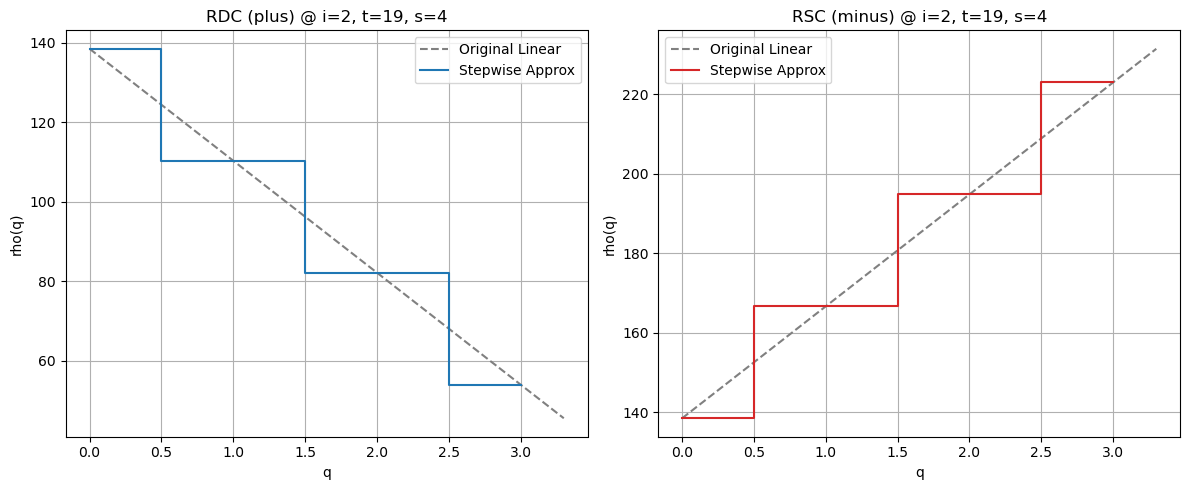

In [127]:
def plot_rho_stepwise_list(rho_plus, rho_minus, rho_plus_piece, rho_minus_piece, target_i, target_t, target_s):
    """
    [목적]
        - 선택된 (i, t, s)에 대해 선형 가격 함수와 stepwise 근사 결과를 함께 시각화

    [입력]
        rho_plus, rho_minus: 원본 선형 계수 (I, T, S, 2)
        rho_plus_piece, rho_minus_piece: 각 (i,t,s)별 계단형 근사 [q_b, p_b] 리스트
        target_i, target_t, target_s: 시각화할 대상 인덱스
    """

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    labels = ['RDC (plus)', 'RSC (minus)']
    colors = ['tab:blue', 'tab:red']
    rho_data = [rho_plus, rho_minus]
    pwl_data = [rho_plus_piece, rho_minus_piece]

    for idx, (rho, pwl_piece, ax, label, color) in enumerate(zip(
        rho_data, pwl_data, axes, labels, colors
    )):
        a, b = rho[target_i, target_t, target_s]
        piecewise = pwl_piece[target_i][target_t][target_s]  # shape (B, 2)
        q_vals = piecewise[:, 0]
        p_vals = piecewise[:, 1]

        # 원본 선형함수
        q_cont = np.linspace(0, max(q_vals) * 1.1 if np.any(q_vals > 0) else 1.0, 200)
        p_cont = a + b * q_cont
        ax.plot(q_cont, p_cont, '--', label='Original Linear', color='gray')

        # 계단형 근사
        ax.step(q_vals, p_vals, where='mid', label='Stepwise Approx', color=color)

        ax.set_title(f"{label} @ i={target_i}, t={target_t}, s={target_s}")
        ax.set_xlabel("q")
        ax.set_ylabel("rho(q)")
        ax.grid(True)
        ax.legend()

    plt.tight_layout()
    plt.show()

plot_rho_stepwise_list(
    rho_plus, rho_minus, 
    rho_plus_piece, rho_minus_piece, 
    target_i=2, target_t=19, target_s=4
)

Model (Linear)

In [ ]:
# target_i = 0

# # === 모델 정의 ===
# model = gp.Model("PWL_Internal_Price")
# model.setParam("MIPGap", 1e-7)

# # === 변수 정의 ===
# x   = model.addVars(T, vtype=GRB.CONTINUOUS, lb=0, name="x")
# yp  = model.addVars(T, S, vtype=GRB.CONTINUOUS, lb=0, name="y_plus")
# ym  = model.addVars(T, S, vtype=GRB.CONTINUOUS, lb=0, name="y_minus")
# z   = model.addVars(T+1, S, vtype=GRB.CONTINUOUS, lb=0, name="z")
# zc  = model.addVars(T, S, vtype=GRB.CONTINUOUS, name="z_charge")
# zd  = model.addVars(T, S, vtype=GRB.CONTINUOUS, name="z_discharge")
# dp  = model.addVars(T, S, vtype=GRB.CONTINUOUS, name="d_plus")
# dm  = model.addVars(T, S, vtype=GRB.CONTINUOUS, name="d_minus")
# p1  = model.addVars(T, S, vtype=GRB.BINARY, name="p1")
# p2  = model.addVars(T, S, vtype=GRB.BINARY, name="p2")
# p3  = model.addVars(T, S, vtype=GRB.BINARY, name="p3")
# p4  = model.addVars(T, S, vtype=GRB.BINARY, name="p4")
# p5  = model.addVars(T, S, vtype=GRB.BINARY, name="p5")
# p6  = model.addVars(T, S, vtype=GRB.BINARY, name="p6")

# model.update()

# ap = {}
# bp = {}
# am = {}
# bm = {}

# for t in range(T):
#     for s in range(S):
#         ap[t, s]  = rho_plus[target_i, t, s, 0]
#         bp[t, s]  = rho_plus[target_i, t, s, 1]
#         am[t, s] = rho_minus[target_i, t, s, 0]
#         bm[t, s] = rho_minus[target_i, t, s, 1]

# # === 목적함수: 선형 부분 + pwl ===
# obj = gp.quicksum(P_DA[t] * x[t] for t in range(T)) + \
#       gp.quicksum((1/S) * (P_RT[t, s] * yp[t, s] - P_PN[t] * ym[t, s]) for t, s in product(range(T), range(S)))
# model.setObjective(obj, GRB.MAXIMIZE)

# # === 제약식 ===
# for t, s in product(range(T), range(S)):
#     model.addConstr(R[target_i, t, s] - x[t] == yp[t, s] - ym[t, s] + zc[t, s] - zd[t, s] + dp[t, s] - dm[t, s])
#     model.addConstr(yp[t, s] + dp[t, s] + zc[t, s] <= R[target_i, t, s])
#     # model.addConstr(x[t] -  R[target_i, t, s] >= ym[t, s] + dm[t, s])
#     model.addConstr(z[t+1, s] == z[t, s] + zc[t, s] - zd[t, s])
#     model.addConstr(zd[t, s] <= z[t, s])
#     model.addConstr(zc[t, s] <= K[target_i] - z[t, s])
#     model.addConstr(z[t, s] >= 0)
#     model.addConstr(z[t, s] <= K[target_i])
#     model.addConstr(yp[t, s] <= M1 * p1[t, s])
#     model.addConstr(ym[t, s] <= M1 * (1 - p1[t, s]))
#     model.addConstr(ym[t, s] <= M1 * p2[t, s])
#     model.addConstr(zc[t, s] <= M1 * (1 - p2[t, s]))
#     model.addConstr(zc[t, s] <= M1 * p3[t, s])
#     model.addConstr(zd[t, s] <= M1 * (1 - p3[t, s]))
#     model.addConstr(dp[t, s] <= M1 * p4[t, s])
#     model.addConstr(dm[t, s] <= M1 * (1 - p4[t, s]))
#     model.addConstr(ym[t, s] <= M1 * p5[t, s])
#     model.addConstr(dp[t, s] <= M1 * (1 - p5[t, s]))
#     model.addConstr(yp[t, s] <= M1 * p6[t, s])
#     model.addConstr(dm[t, s] <= M1 * (1 - p6[t, s]))

# for s in range(S):
#     model.addConstr(z[0, s] == K0[target_i])

# # === Piecewise Linear Objective 적용 ===
# for t, s in product(range(T), range(S)):
#     a_p, b_p = rho_plus[target_i, t, s]
#     a_m, b_m = rho_minus[target_i, t, s]

#     MAX = max(R[target_i, t, s], K[target_i])

#     model.setPWLObj(
#         dp[t, s],
#         [0, MAX],
#         [a_p * 0, a_p * MAX + b_p * MAX]
#     )

#     model.setPWLObj(
#         dm[t, s],
#         [0, MAX],
#         [-a_m * 0, -a_m * MAX - b_m * MAX]
#     )

# # === 최적화 ===
# model.optimize()

# x_vals = np.array([x[t].X for t in range(T)])
# yp_vals = np.array([[yp[t, s].X for s in range(S)] for t in range(T)])
# ym_vals = np.array([[ym[t, s].X for s in range(S)] for t in range(T)])
# z_vals = np.array([[z[t, s].X for s in range(S)] for t in range(T+1)])
# zc_vals = np.array([[zc[t, s].X for s in range(S)] for t in range(T)])
# zd_vals = np.array([[zd[t, s].X for s in range(S)] for t in range(T)])
# dp_vals = np.array([[dp[t, s].X for s in range(S)] for t in range(T)])
# dm_vals = np.array([[dm[t, s].X for s in range(S)] for t in range(T)])

In [135]:
# === 모델 생성 ===
model = gp.Model("PWL_Internal_Optimization")
model.setParam("MIPGap", 1e-7)

# === 변수 정의 ===
x = model.addVars(T, vtype=GRB.CONTINUOUS, lb=0, name="x")
yp = model.addVars(T, S, vtype=GRB.CONTINUOUS, lb=0, name="y_plus")
ym = model.addVars(T, S, vtype=GRB.CONTINUOUS, lb=0, name="y_minus")
z = model.addVars(T+1, S, vtype=GRB.CONTINUOUS, lb=0, name="z")
zc = model.addVars(T, S, vtype=GRB.CONTINUOUS, lb=0, name="z_charge")
zd = model.addVars(T, S, vtype=GRB.CONTINUOUS, lb=0, name="z_discharge")
dp = model.addVars(T, S, vtype=GRB.CONTINUOUS, lb=0, name="d_plus")
dm = model.addVars(T, S, vtype=GRB.CONTINUOUS, lb=0, name="d_minus")

p1  = model.addVars(T, S, vtype=GRB.BINARY, name="p1")
p2  = model.addVars(T, S, vtype=GRB.BINARY, name="p2")
p3  = model.addVars(T, S, vtype=GRB.BINARY, name="p3")
p4  = model.addVars(T, S, vtype=GRB.BINARY, name="p4")
p5  = model.addVars(T, S, vtype=GRB.BINARY, name="p5")
p6  = model.addVars(T, S, vtype=GRB.BINARY, name="p6")

# Stepwise variables
w_plus = {}
u_plus = {}
w_minus = {}
u_minus = {}

for t in range(T):
    for s in range(S):
        Bp = B_map_plus[target_i, t, s]
        Bm = B_map_minus[target_i, t, s]
        for b in range(Bp):
            w_plus[t, s, b] = model.addVar(vtype=GRB.CONTINUOUS, lb=0, name=f"w_plus_{t}_{s}_{b}")
            u_plus[t, s, b] = model.addVar(vtype=GRB.BINARY, name=f"u_plus_{t}_{s}_{b}")
        for b in range(Bm):
            w_minus[t, s, b] = model.addVar(vtype=GRB.CONTINUOUS, lb=0, name=f"w_minus_{t}_{s}_{b}")
            u_minus[t, s, b] = model.addVar(vtype=GRB.BINARY, name=f"u_minus_{t}_{s}_{b}")

model.update()

# === 목적함수 정의 ===
obj = gp.quicksum(P_DA[t] * x[t] for t in range(T)) \
    + gp.quicksum((1/S) * (P_RT[t, s] * yp[t, s] - P_PN[t] * ym[t, s]) for t in range(T) for s in range(S)) \
    + gp.quicksum((1/S) * (
        gp.quicksum(
            rho_plus_piece[target_i][t][s][b][1] * (w_plus[t, s, b] + u_plus[t, s, b] * rho_plus_piece[target_i][t][s][b][0])
            for b in range(B_map_plus[target_i, t, s])
        ) -
        gp.quicksum(
            rho_minus_piece[target_i][t][s][b][1] * (w_minus[t, s, b] + u_minus[t, s, b] * rho_minus_piece[target_i][t][s][b][0])
            for b in range(B_map_minus[target_i, t, s])
        )
    ) for t in range(T) for s in range(S))

model.setObjective(obj, GRB.MAXIMIZE)

# === 제약식 ===
for t, s in product(range(T), range(S)):
    # 기본 수지식
    model.addConstr(R[target_i, t, s] - x[t] == yp[t, s] - ym[t, s] + zc[t, s] - zd[t, s] + dp[t, s] - dm[t, s])
    model.addConstr(yp[t, s] + dp[t, s] + zc[t, s] <= R[target_i, t, s])
    model.addConstr(z[t+1, s] == z[t, s] + zc[t, s] - zd[t, s])
    model.addConstr(zd[t, s] <= z[t, s])
    model.addConstr(zc[t, s] <= K[target_i] - z[t, s])
    model.addConstr(z[t, s] <= K[target_i])
    model.addConstr(z[t, s] >= 0)
    model.addConstr(yp[t, s] <= M1 * p1[t, s])
    model.addConstr(ym[t, s] <= M1 * (1 - p1[t, s]))
    model.addConstr(ym[t, s] <= M1 * p2[t, s])
    model.addConstr(zc[t, s] <= M1 * (1 - p2[t, s]))
    model.addConstr(zc[t, s] <= M1 * p3[t, s])
    model.addConstr(zd[t, s] <= M1 * (1 - p3[t, s]))
    model.addConstr(dp[t, s] <= M1 * p4[t, s])
    model.addConstr(dm[t, s] <= M1 * (1 - p4[t, s]))
    model.addConstr(ym[t, s] <= M1 * p5[t, s])
    model.addConstr(dp[t, s] <= M1 * (1 - p5[t, s]))
    model.addConstr(yp[t, s] <= M1 * p6[t, s])
    model.addConstr(dm[t, s] <= M1 * (1 - p6[t, s]))

    # piecewise aggregation
    model.addConstr(dp[t, s] == gp.quicksum(w_plus[t, s, b] + u_plus[t, s, b] * rho_plus_piece[target_i][t][s][b][0]
                                            for b in range(B_map_plus[target_i, t, s])))
    model.addConstr(dm[t, s] == gp.quicksum(w_minus[t, s, b] + u_minus[t, s, b] * rho_minus_piece[target_i][t][s][b][0]
                                            for b in range(B_map_minus[target_i, t, s])))

    model.addConstr(gp.quicksum(u_plus[t, s, b] for b in range(B_map_plus[target_i, t, s])) == 1)
    model.addConstr(gp.quicksum(u_minus[t, s, b] for b in range(B_map_minus[target_i, t, s])) == 1)

    for b in range(B_map_plus[target_i, t, s]):
        width = rho_plus_piece[target_i][t][s][b][0]
        model.addConstr(w_plus[t, s, b] <= u_plus[t, s, b] * width)
    for b in range(B_map_minus[target_i, t, s]):
        width = rho_minus_piece[target_i][t][s][b][0]
        model.addConstr(w_minus[t, s, b] <= u_minus[t, s, b] * width)

# 초기 상태
for s in range(S):
    model.addConstr(z[0, s] == K0[target_i])

model.optimize()

x_vals = np.array([x[t].X for t in range(T)])
yp_vals = np.array([[yp[t, s].X for s in range(S)] for t in range(T)])
ym_vals = np.array([[ym[t, s].X for s in range(S)] for t in range(T)])
z_vals = np.array([[z[t, s].X for s in range(S)] for t in range(T+1)])
zc_vals = np.array([[zc[t, s].X for s in range(S)] for t in range(T)])
zd_vals = np.array([[zd[t, s].X for s in range(S)] for t in range(T)])
dp_vals = np.array([[dp[t, s].X for s in range(S)] for t in range(T)])
dm_vals = np.array([[dm[t, s].X for s in range(S)] for t in range(T)])

Set parameter MIPGap to value 1e-07
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
MIPGap  1e-07

Optimize a model with 38282 rows, 60728 columns and 156290 nonzeros
Model fingerprint: 0xa629c545
Variable types: 30626 continuous, 30102 integer (30102 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+02]
  Objective range  [2e-02, 2e+07]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+02]
Presolve removed 12798 rows and 15319 columns
Presolve time: 0.18s
Presolved: 25484 rows, 45409 columns, 119071 nonzeros
Variable types: 22987 continuous, 22422 integer (22422 binary)
Found heuristic solution: objective 235880.93933
Deterministic concurrent LP optimizer: primal and dual simplex
Showing primal log only...

Concurrent spin time: 0.00s

Solved with dual simplex
Extra simplex iterations after uncrush: 23



In [136]:
header = (
    f"{'s':>2} {'t':>2} | "
    f"{'R':>8} {'x':>8} {'y+':>8} {'y-':>8} "
    f"{'d+':>8} {'d-':>8} {'zc':>8} {'zd':>8} {'z':>8}\n"
    + "-" * 90
)
print(header)

for s, t in product(range(S), range(T)):
    print(
        f"{s:>2} {t:>2} | "
        f"{R[target_i, t, s]:>8.2f} {x_vals[t]:>8.2f} {yp_vals[t, s]:>8.2f} {ym_vals[t, s]:>8.2f} "
        f"{dp_vals[t, s]:>8.2f} {dm_vals[t, s]:>8.2f} {zc_vals[t, s]:>8.2f} {zd_vals[t, s]:>8.2f} {z_vals[t, s]:>8.2f}"
    )

 s  t |        R        x       y+       y-       d+       d-       zc       zd        z
------------------------------------------------------------------------------------------
 0  0 |     0.00     0.00     0.00     0.00     0.00     0.00     0.00     0.00     0.00
 0  1 |     0.00     0.00     0.00     0.00     0.00     0.00     0.00     0.00     0.00
 0  2 |     0.00     0.00     0.00     0.00     0.00     0.00     0.00     0.00     0.00
 0  3 |     0.00     0.00     0.00     0.00     0.00     0.00     0.00     0.00     0.00
 0  4 |     0.00     0.00     0.00     0.00     0.00     0.00     0.00     0.00     0.00
 0  5 |     0.00     0.00     0.00     0.00     0.00     0.00     0.00     0.00     0.00
 0  6 |     1.00     0.00     0.00     0.00     0.00     0.00     1.00     0.00     0.00
 0  7 |     2.00     0.00     2.00     0.00     0.00     0.00     0.00     0.00     1.00
 0  8 |     2.00     0.00     0.00     0.00     0.00     0.00     2.00     0.00     1.00
 0  9 |    57.00   